(dc_opf:title)=
# Optimal DC Power Flow

The optimal power flow problem minimizes the overall operating cost in a electricity network while subject to a number of generation and transmission constraints. The DC model is a widely used linearized approximation of the actual nonlinear power flow model, and it can be written as

```{math}
\begin{align}
\min~&\sum\limits_{i=1}^m (a_ig_i^2 + b_ig_i + c_i) \\
\text{s.t.}~&\pmb{B}_{\text{bus}} \pmb{v} + \pmb{I}_{\text{bg}} \pmb{g} = \pmb{L} \\
&|\pmb{B}_{\text{f}} \pmb{v}| \leq \pmb{R} \\
&P_i^{\min} \leq g_i \leq P_i^{\max} &\forall i = 1, 2, ..., m \\
&v_{ref} = 0,
\end{align}
```

where $n$ is the number of buses, and $m$ is the number of generators. The decision variables:

- $v_j$: the voltage angle of bus $j$, with $j=1, 2, ..., n$;
- $g_i$: the output of the $i$th generator, with $i=1, 2, ..., m$,

and parameters:

- $\pmb{B}_{\text{bus}}$: the matrix of reciprocals of reactance between buses;
- $\pmb{I}_{\text{bg}}$: the matrix that places generations to their corresponding buses;
- $\pmb{L}$: the array of electricity load at each bus;
- $\pmb{B}_{\text{f}}$: the matrix for calculating the transmitted power;
- $P_i^{\min}$ and $P_i^{\max}$: the minimum and maximum output of the $i$th generator;
- $\pmb{R}$: the array of transmission line capacity ratings.

In this case study, we consider the {cite:ps}`RTS_Task_Force_1999ieee`, and the dataset is generated according to the one used in [MATPOWER](https://matpower.org/). You may find the dataset as an Excel file [ieee_rts.xlsx](ieee_rts.xlsx). The following code is used to import system parameters from the file.

In [1]:
# Load data from the Excel file
import pandas as pd

Bbus_df = pd.read_excel('ieee_rts.xlsx', sheet_name='Bbus')
Bf_df = pd.read_excel('ieee_rts.xlsx', sheet_name='Bf')
Gen_df = pd.read_excel('ieee_rts.xlsx', sheet_name='Gen')
Rates_df = pd.read_excel('ieee_rts.xlsx', sheet_name='Rates')
Load_df = pd.read_excel('ieee_rts.xlsx', sheet_name='Load')

Bbus = Bbus_df.values                            # Bbus array
Bf = Bf_df.values                                # Bf array

R = Rates_df['Rate_A'].values                    # line capacity ratings
GBus = Gen_df['GBus'].values                     # generator buses
Pmin = Gen_df['Pmin'].values                     # minimum outputs of generators
Pmax = Gen_df['Pmax'].values                     # maximum outputs of generators
C = Gen_df.loc[:, 'Cost_a':'Cost_c'].values      # cost coefficients of generators
L = Load_df['Load'].values                       # electricity loads

n = Bf.shape[1]                                  # n: Number of buses
m = len(GBus)                                    # m: Number of generators

The DC optimal power flow problem can be solved by the following Python code.

In [2]:
from rsome import ro
from rsome import msk_solver as msk
from rsome import sumsqr
import numpy as np

model = ro.Model()

v = model.dvar(n)                                            # decision as voltage angles
g = model.dvar(m)                                            # decision as the generation output

obj = sumsqr(C[:, 0]**0.5 * g) + C[:, 1]@g + C[:, 2].sum()   # quadratic objective function
model.min(obj)                                               # minimize the objective                   

I_bg = np.zeros((n, m))
I_bg[GBus-1, range(m)] = 1                                   # array of generator buses
model.st(Bbus@v + I_bg@g == L)                               # power balance equation
model.st(abs(Bf@v) <= R)                                     # transmission line capacities
model.st(g >= Pmin, g <= Pmax)                               # output capacities of generators
Ref = 12                                                     # index of the reference bus
model.st(v[Ref] == 0)                                        # set the reference bus

model.solve(msk)                                             # solve the problem by Mosek

Being solved by Mosek...
Solution status: Optimal
Running time: 0.0287s


The optimal generation decision and the objective value are shown below.

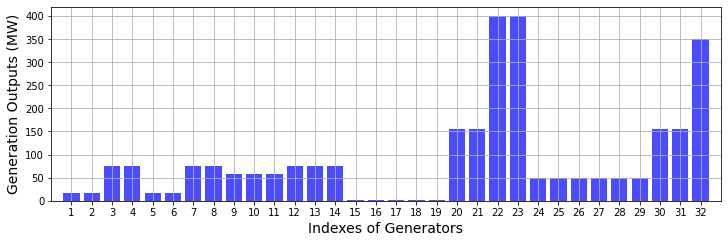

Optimal generation cost: 61001.24


In [3]:
import matplotlib.pyplot as plt

gs = g.get()
index = range(1, m+1)

plt.figure(figsize=(12, 3.5))
plt.bar(index, gs, color='b', alpha=0.7)
plt.xlabel('Indexes of Generators', fontsize=14)
plt.ylabel('Generation Outputs (MW)', fontsize=14)
plt.xticks(index)
plt.xlim([0, m+1])
plt.grid()
plt.show()

print(f'Optimal generation cost: {model.get():0.2f}')

<br>

---

<font size="5">Reference</font>

```{bibliography}
:filter: docname in docnames
```